Importing Necessary Libraries:

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

In [13]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),   # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))   # Normalize pixel values to range [-1, 1]
])

# Load FashionMNIST training set
train_set = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Load FashionMNIST test set
test_set = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [14]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=32,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=32,
    shuffle=True
)

Here we can see the target classes:

In [15]:
# Output labels
print(train_set.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Let's see the number of channels and pixels in each image:

In [16]:
# size of the images
print(train_set[0][0].shape)

torch.Size([1, 28, 28])


Images are in grayscale form, so we have only one channel.

Here we can have a look at the data we are working with:

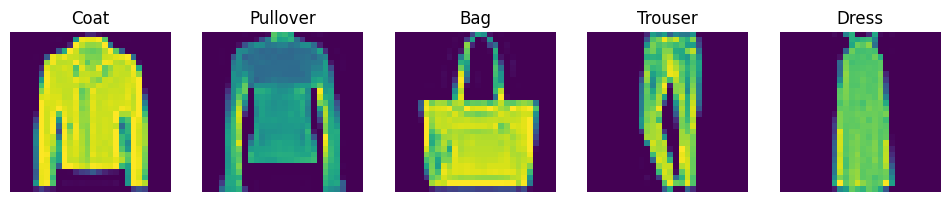

In [17]:
import matplotlib.pyplot as plt
# Get a few random images from the training set
indices = np.random.choice(len(train_set), 5, replace=False)
images = [train_set[i][0] for i in indices]
labels = [train_set[i][1] for i in indices]

# Plot the images with their categories
fig, ax = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    ax[i].imshow(images[i].permute(1, 2, 0).numpy())
    ax[i].set_title(train_set.classes[labels[i]])
    ax[i].axis('off')
plt.show()

In [18]:
# Define the neural network with given parameters : num of hidden layers, num of neurons in each layer
class NeuralNetwork(nn.Module):
    def __init__(self, num_hidden_layers, num_neurons, num_classes, dropout_prob=0):
        super(NeuralNetwork, self).__init__()
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.layers.append(nn.Linear(784, num_neurons[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(self.dropout)
        for i in range(1, num_hidden_layers):
            self.layers.append(nn.Linear(num_neurons[i-1], num_neurons[i]))
            self.layers.append(nn.ReLU())
            self.layers.append(self.dropout)
        self.layers.append(nn.Linear(num_neurons[-1], num_classes))

    def forward(self, x):
        x = x.flatten(start_dim=1)
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x

In [43]:
# Define the convolutional neural network with given parameters : dropout probability, number of classes , 3 convolutional layers
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, dropout_prob, num_classes):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.dropout(nn.functional.relu(self.conv1(x))))
        x = self.pool(self.dropout(nn.functional.relu(self.conv2(x))))
        x = self.pool(self.dropout(nn.functional.relu(self.conv3(x))))
        x = x.flatten(start_dim=1)
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [19]:
def evaluate(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [20]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    train_accs = []
    val_accs = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_total = 0
        train_correct = 0
        for i, (images, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update training statistics
            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Print progress every 100 batches
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Compute train and validation accuracies
        train_acc = train_correct / train_total
        val_acc = evaluate(model, val_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        # Save train loss and accuracies for plotting
        train_losses.append(train_loss / len(train_loader.dataset))
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    return train_losses, train_accs, val_accs 

In [55]:
# Define the model
model = NeuralNetwork(num_hidden_layers=2, num_neurons=[256, 64], num_classes=10)
print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, train_accs, val_accs = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=20)

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
  (dropout): Dropout(p=0, inplace=False)
)
Epoch [1/20], Step [100/1875], Loss: 0.6558
Epoch [1/20], Step [200/1875], Loss: 0.4371
Epoch [1/20], Step [300/1875], Loss: 0.8061
Epoch [1/20], Step [400/1875], Loss: 0.5483
Epoch [1/20], Step [500/1875], Loss: 0.3215
Epoch [1/20], Step [600/1875], Loss: 0.3509
Epoch [1/20], Step [700/1875], Loss: 0.3347
Epoch [1/20], Step [800/1875], Loss: 0.2994
Epoch [1/20], Step [900/1875], Loss: 0.4010
Epoch [1/20], Step [1000/1875], Loss: 0.6662
Epoch [1/20], Step [1100/1875], Loss: 0.4556
Epoch [1/20], Step [1200/1875], Loss: 0.6894
Epoch [1/20], Step [1300/1875], Loss: 0.3951
Epoch [1/20], Step [1400/1875], Loss: 0.3170
Epoc

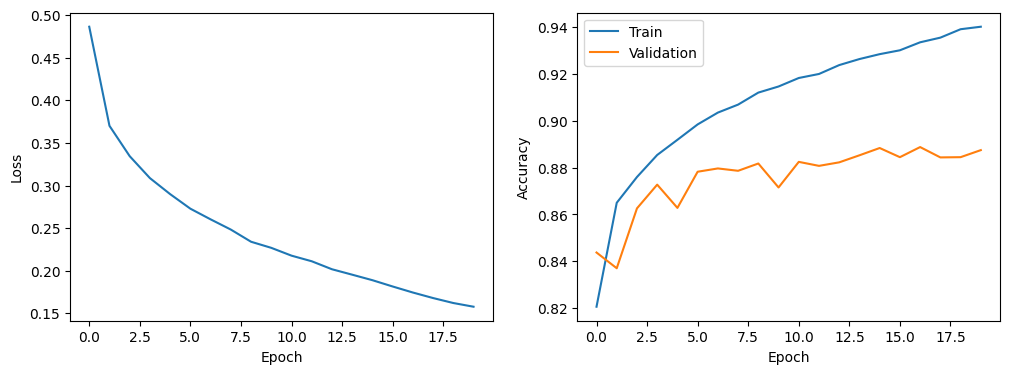

In [56]:
# Plot the training loss and accuracies
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(train_accs, label='Train')
ax[1].plot(val_accs, label='Validation')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

Here we can see the predictions of our model and true labels:

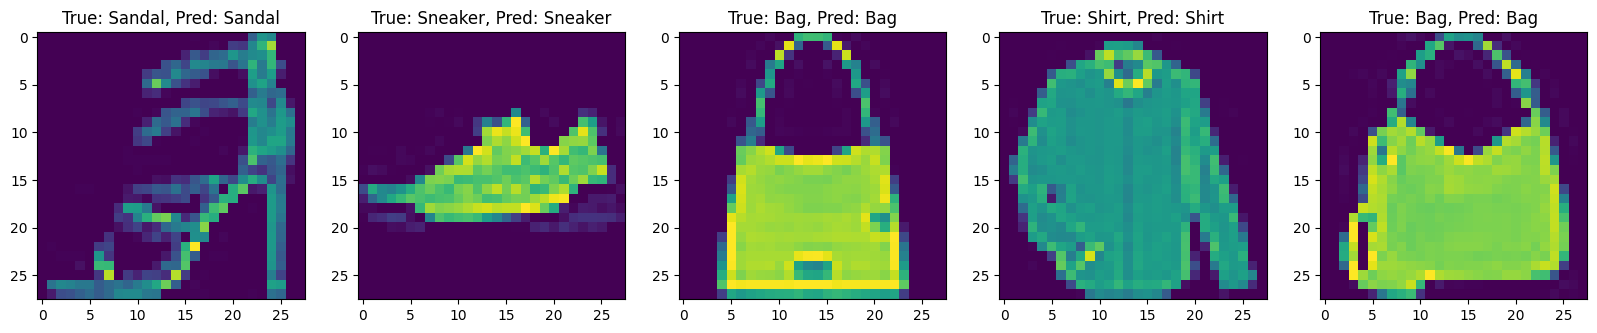

In [60]:
# Set model to evaluation mode
model.eval()

# Get a batch of test data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Convert labels and predictions to numpy arrays and to categorical labels
labels = labels.cpu().numpy()
predicted = predicted.cpu().numpy()
images = images.cpu()
# Show some predictions and true labels
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(images[i].permute(1, 2, 0).numpy())
    axs[i].set_title(f'True: {test_set.classes[labels[i]]}, Pred: {test_set.classes[predicted[i]]}')
plt.show()

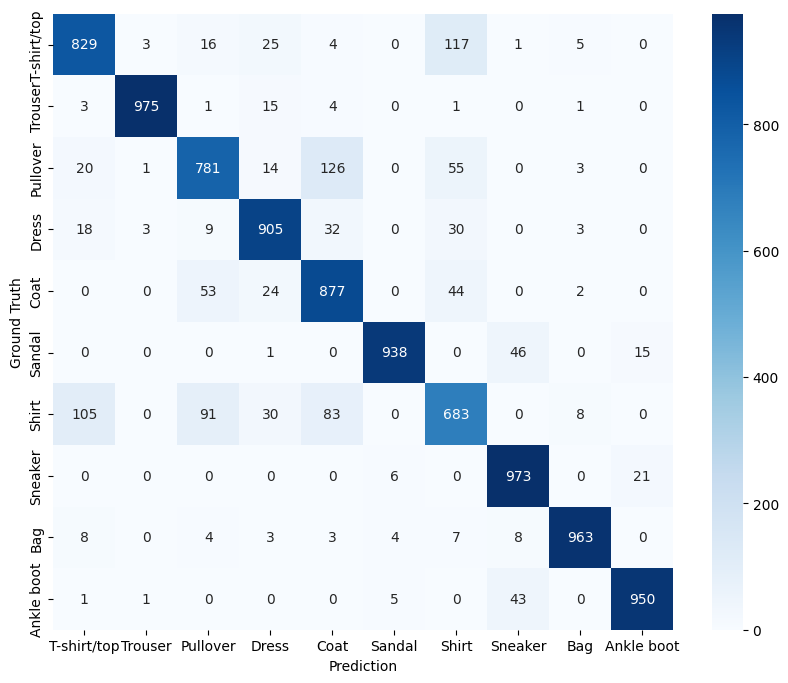

In [61]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# test the model on the test set and plot the confusion matrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred_list.append(predicted.cpu().numpy())
        y_true_list.append(labels.cpu().numpy())
y_pred_list = np.concatenate(y_pred_list).ravel().tolist()
y_true_list = np.concatenate(y_true_list).ravel().tolist()
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list), index=test_set.classes, columns=test_set.classes)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show()

In [62]:
# Precision, Recall, F1 score
from sklearn.metrics import classification_report
print(classification_report(y_true_list, y_pred_list, target_names=test_set.classes))

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.83      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.82      0.78      0.80      1000
       Dress       0.89      0.91      0.90      1000
        Coat       0.78      0.88      0.82      1000
      Sandal       0.98      0.94      0.96      1000
       Shirt       0.73      0.68      0.71      1000
     Sneaker       0.91      0.97      0.94      1000
         Bag       0.98      0.96      0.97      1000
  Ankle boot       0.96      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

